# Profiling Image-based Social Sensing Dataset 

In [1]:
import io
import pandas as pd

#define null values
missing = ["-0"]
df = pd.read_csv('datasets/162_social_distancing_week_34_results_geoloc_ok.csv', na_values=missing)

#assign a name to the first column that is unamed
#df = df.rename(columns={df.columns[0]: 'line'})

In [2]:
#print the columns names with their index in order to make it easier to reference them later
cols = list(df.columns)
length = len(df[cols[0]])

i = 0
while(i<len(cols)):
    print(i,cols[i])
    i+=1

0 Unnamed: 0
1 id_x
2 task_id
3 id_y
4 info_0
5 info_1
6 info_2
7 info_3
8 info_4_0
9 info_4_1
10 info_4_2
11 info_4_3
12 info_5
13 info_6
14 info_7
15 info_8
16 info_9
17 info_10
18 info_11
19 calibration
20 created
21 fav_user_ids
22 id
23 info_CIME_coordinates
24 info_CIME_geolocation_string
25 info_bounding_box
26 info_country
27 info_country_code
28 info_country_or_territory
29 info_created_at
30 info_id
31 info_id_str
32 info_language_code
33 info_media_url
34 info_type
35 info_url
36 info_user_loc
37 n_answers
38 priority_0
39 project_id
40 quorum
41 state


In [3]:
#read a dataset that contains data about all the countries in the world and select only the columns relative to the codes
countries = pd.read_csv('datasets/ISO 3166-2  countries.csv')
countries_codes = countries[["alpha-2","alpha-3"]]

#read dataset that contains association between language code and country code
languages = pd.read_csv('datasets/ietf-language-tags_csv.csv')
languages = languages[["langType","territory"]]

#integrate the two datasets
languages = pd.merge(languages, countries_codes, how="inner", left_on=['territory'], right_on=['alpha-2'])
languages = languages.drop_duplicates().dropna()

#for cleaness select only the columns relative to the post id, the alpha-3 country code and the language code
df_reduced = df[[cols[22]] + [cols[27]] + [cols[32]]]

In [4]:
#left join the data frame about the posts with the data frame with all the languages spoken in each country
languages_merged = pd.merge(df_reduced, languages, how="left",left_on=['info_country_code'], right_on=['alpha-3'])
#select the rows that did not match
languages_not_matching = languages_merged[languages_merged.isnull().any(axis=1)]

#Countries for which the tweet was done in a language not spoken in that country
languages_not_matching

,id,info_country_code,info_language_code,langType,territory,alpha-2,alpha-3
5014,129974,NAM,en,NaN,NaN,NaN,NaN
15452,132977,NAM,en,NaN,NaN,NaN,NaN
16174,133647,NAM,en,NaN,NaN,NaN,NaN


In [5]:
#compute a ratio for language in the post not matching country's language
df_length = len(df[cols[0]])
not_matching_ratio = len(languages_not_matching[languages_not_matching.columns[0]]) / df_length
print("Posts where the language doesn't match the country's languages: "+str(100*not_matching_ratio)[0:5]+" %")

Posts where the language doesn't match the country's languages: 0.055 %


## Completeness

In [6]:
#compl is the compleateness measure for each column
compl = 100 *(length - df.isnull().sum()) / length
#to have the columns sorted
#compl = compl.sort_values(ascending=False)

#Keep only the rows that are incomplete
compl = compl[compl < 100]

Completeness:
AxesSubplot(0.125,0.125;0.775x0.755)


(0.0, 145.0)

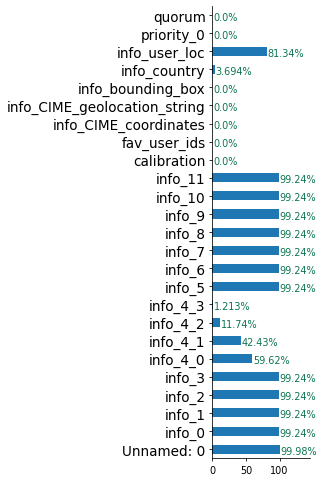

In [7]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=14)
figure(figsize=(5, 7), dpi=70)
ax = plt.axes()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


if (compl.size == 0):
    print("All columns are 100% complete")
else:
    #print incomplete columns
    print("Completeness:")
    for i, v in enumerate(compl):
        plt.text(v + 1, i-0.25, str(v)[0:5] +"%", color='#0C764F',fontsize=10)
print(compl.plot.barh())
plt.tight_layout()
plt.xlim([0, 145])
#ax.set_facecolor("#FCF7EE")

#save the image
#plt.savefig("imgs/completeness_1.png")    

In [8]:
#create another dataframe where also Not Answered counts as null
missing = ["-0","Not answered"]
df_2 = pd.read_csv('datasets/162_social_distancing_week_34_results_geoloc_ok.csv', na_values=missing)

#compl_2 is the compleateness measure for each column considering Not Answerd as null
compl_2 = 100 *(length - df_2.isnull().sum()) / length
#compl_2 = compl_2.sort_values(ascending=False)

#Keep only the rows that are incomplete
compl_2 = compl_2[compl_2 < 100]

In [9]:
#convert Series to Dataframe
compl_df = compl.to_frame().reset_index()
compl_2_df = compl_2.to_frame().reset_index()

#rename columns for joining
compl_df = compl_df.rename(columns={compl_df.columns[0]: 'field'})
compl_df = compl_df.rename(columns={compl_df.columns[1]: 'completeness_1'})
compl_2_df = compl_2_df.rename(columns={compl_2_df.columns[0]: 'field'})
compl_2_df = compl_2_df.rename(columns={compl_2_df.columns[1]: 'completeness_2'})

compl_merged = pd.merge(compl_df, compl_2_df, how="inner", left_on=['field'], right_on=['field'])
#select only the columns where the completeness measure changes over the two datasets
compl_diff = compl_merged.loc[compl_merged["completeness_1"] != compl_merged["completeness_2"]]

Completeness:
AxesSubplot(0.125,0.125;0.775x0.755)


(0.0, 145.0)

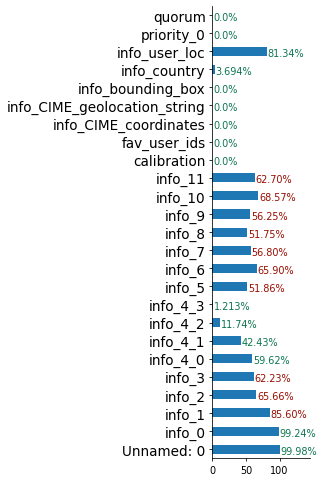

In [10]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=14)
figure(figsize=(5, 7), dpi=70)
ax = plt.axes()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)


if (compl_2.size == 0):
    print("All columns are 100% complete")
else:
    print("Completeness:")
    for i, v in enumerate(compl_2):
        #if an attribute has a different completeness measure when considering Not Answered as null print it in another color
        if((compl_diff[compl_diff["field"].str.contains(compl_2.axes[:][0][i])]).size):
            plt.text(v + 1, i-0.25, str(v)[0:5] +"%", color='#990D00',fontsize=10)
        else:
            plt.text(v + 1, i-0.25, str(v)[0:5] +"%", color='#0C764F',fontsize=10)
print(compl_2.plot.barh())
plt.tight_layout()
plt.xlim([0, 145])
#ax.set_facecolor("#FCF7EE")

#save the image
#plt.savefig("imgs/completeness_2.png")

## Coverage

In [11]:
#Count how many posts for each country
post_per_country = df.groupby(by="info_country_code").count().reset_index()
post_per_country = post_per_country.iloc[:,0:2]
post_per_country = post_per_country.rename(columns={post_per_country.columns[1]: 'Posts'})
post_per_country = post_per_country.sort_values("Posts",ascending=False)
post_per_country = post_per_country.rename(columns={post_per_country.columns[0]:"Country Code"})
post_per_country

,Country Code,Posts
134,USA,1125
80,MEX,532
35,ESP,263
3,ARG,261
15,BRA,226
...,...,...
50,HKG,1
118,SJM,1
119,SLB,1
98,OMN,1


In [12]:
#load a dataset with the population in each country
world_pop = pd.read_csv('datasets/API_SP.POP.TOTL_DS2_en_csv_v2_2445260.csv')
world_pop = world_pop[list(world_pop.columns[0:2]) + [world_pop.columns[-2]]]
world_pop = world_pop.rename(columns={world_pop.columns[2]:"Population"})

posts_population = post_per_country.set_index("Country Code").join(world_pop.set_index("Country Code"))
columns_titles = ["Country Name", "Posts","Population","Posts_Per_Person"]
posts_population=posts_population.reindex(columns=columns_titles)

#compute the posts per person
posts_population["Posts_Per_Person"] = posts_population["Posts"] / posts_population["Population"]
posts_population_ratio = posts_population.sort_values("Posts_Per_Person",ascending=False)

#remove countries with small population since with few data they easily become outliers
posts_population_ratio = posts_population_ratio.loc[posts_population_ratio["Population"] > 100000]

posts_population_ratio

,Country Name,Posts,Population,Posts_Per_Person
Country Code,,,,
FSM,"Micronesia, Fed. Sts.",5,113815.0,4.393094e-05
MNE,Montenegro,9,622028.0,1.446880e-05
PRI,Puerto Rico,39,3193694.0,1.221156e-05
SLV,El Salvador,69,6453553.0,1.069178e-05
PAN,Panama,32,4246439.0,7.535726e-06
...,...,...,...,...
ETH,Ethiopia,4,112078730.0,3.568920e-08
YEM,"Yemen, Rep.",1,29161922.0,3.429129e-08
MOZ,Mozambique,1,30366036.0,3.293153e-08


### Plot the maps

In [13]:
import geopandas as gpd

# set the filepath and load
fp = "world_map/ne_110m_admin_0_countries.shp"
map_df = gpd.read_file(fp)
post_per_country_map = map_df.set_index("ADM0_A3").join(posts_population_ratio)

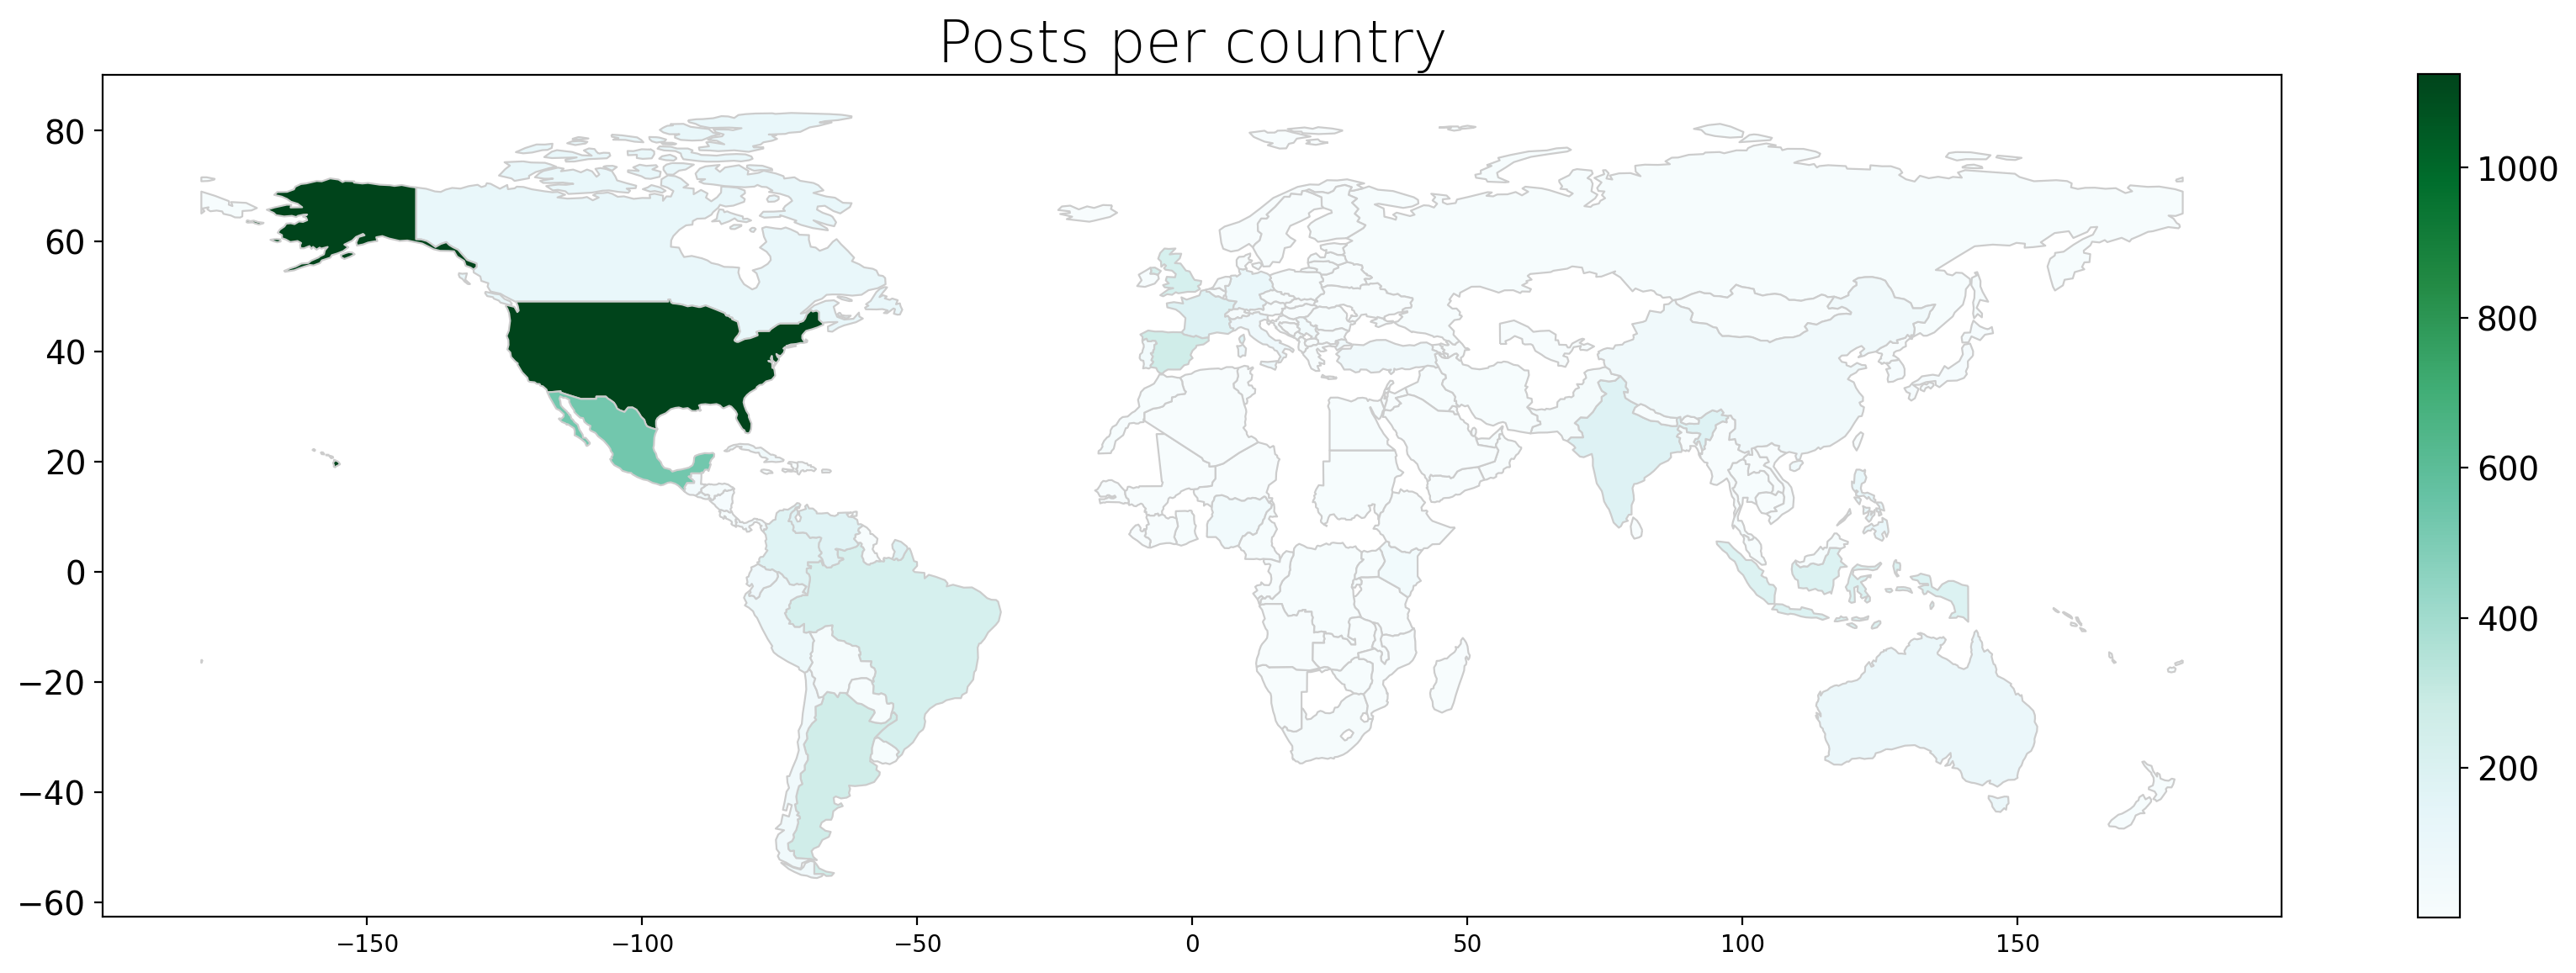

In [14]:
# set a variable that will call whatever column we want to visualise on the map
variable = "Posts"
# set the range for the choropleth
vmin, vmax = posts_population_ratio.Posts.max(), posts_population_ratio.Posts.min()


# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(17, 6),dpi=200)

post_per_country_map.plot(column=variable, cmap="BuGn", linewidth=0.8, ax=ax, edgecolor="0.8")

# add a title
ax.set_title("Posts per country", fontdict={"fontsize": "25", "fontweight" : "3"})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="BuGn", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
# add the colorbar to the figure
fig.colorbar( sm,shrink=0.9)
plt.tight_layout()

#save the image
#plt.savefig("imgs/posts per country.png")

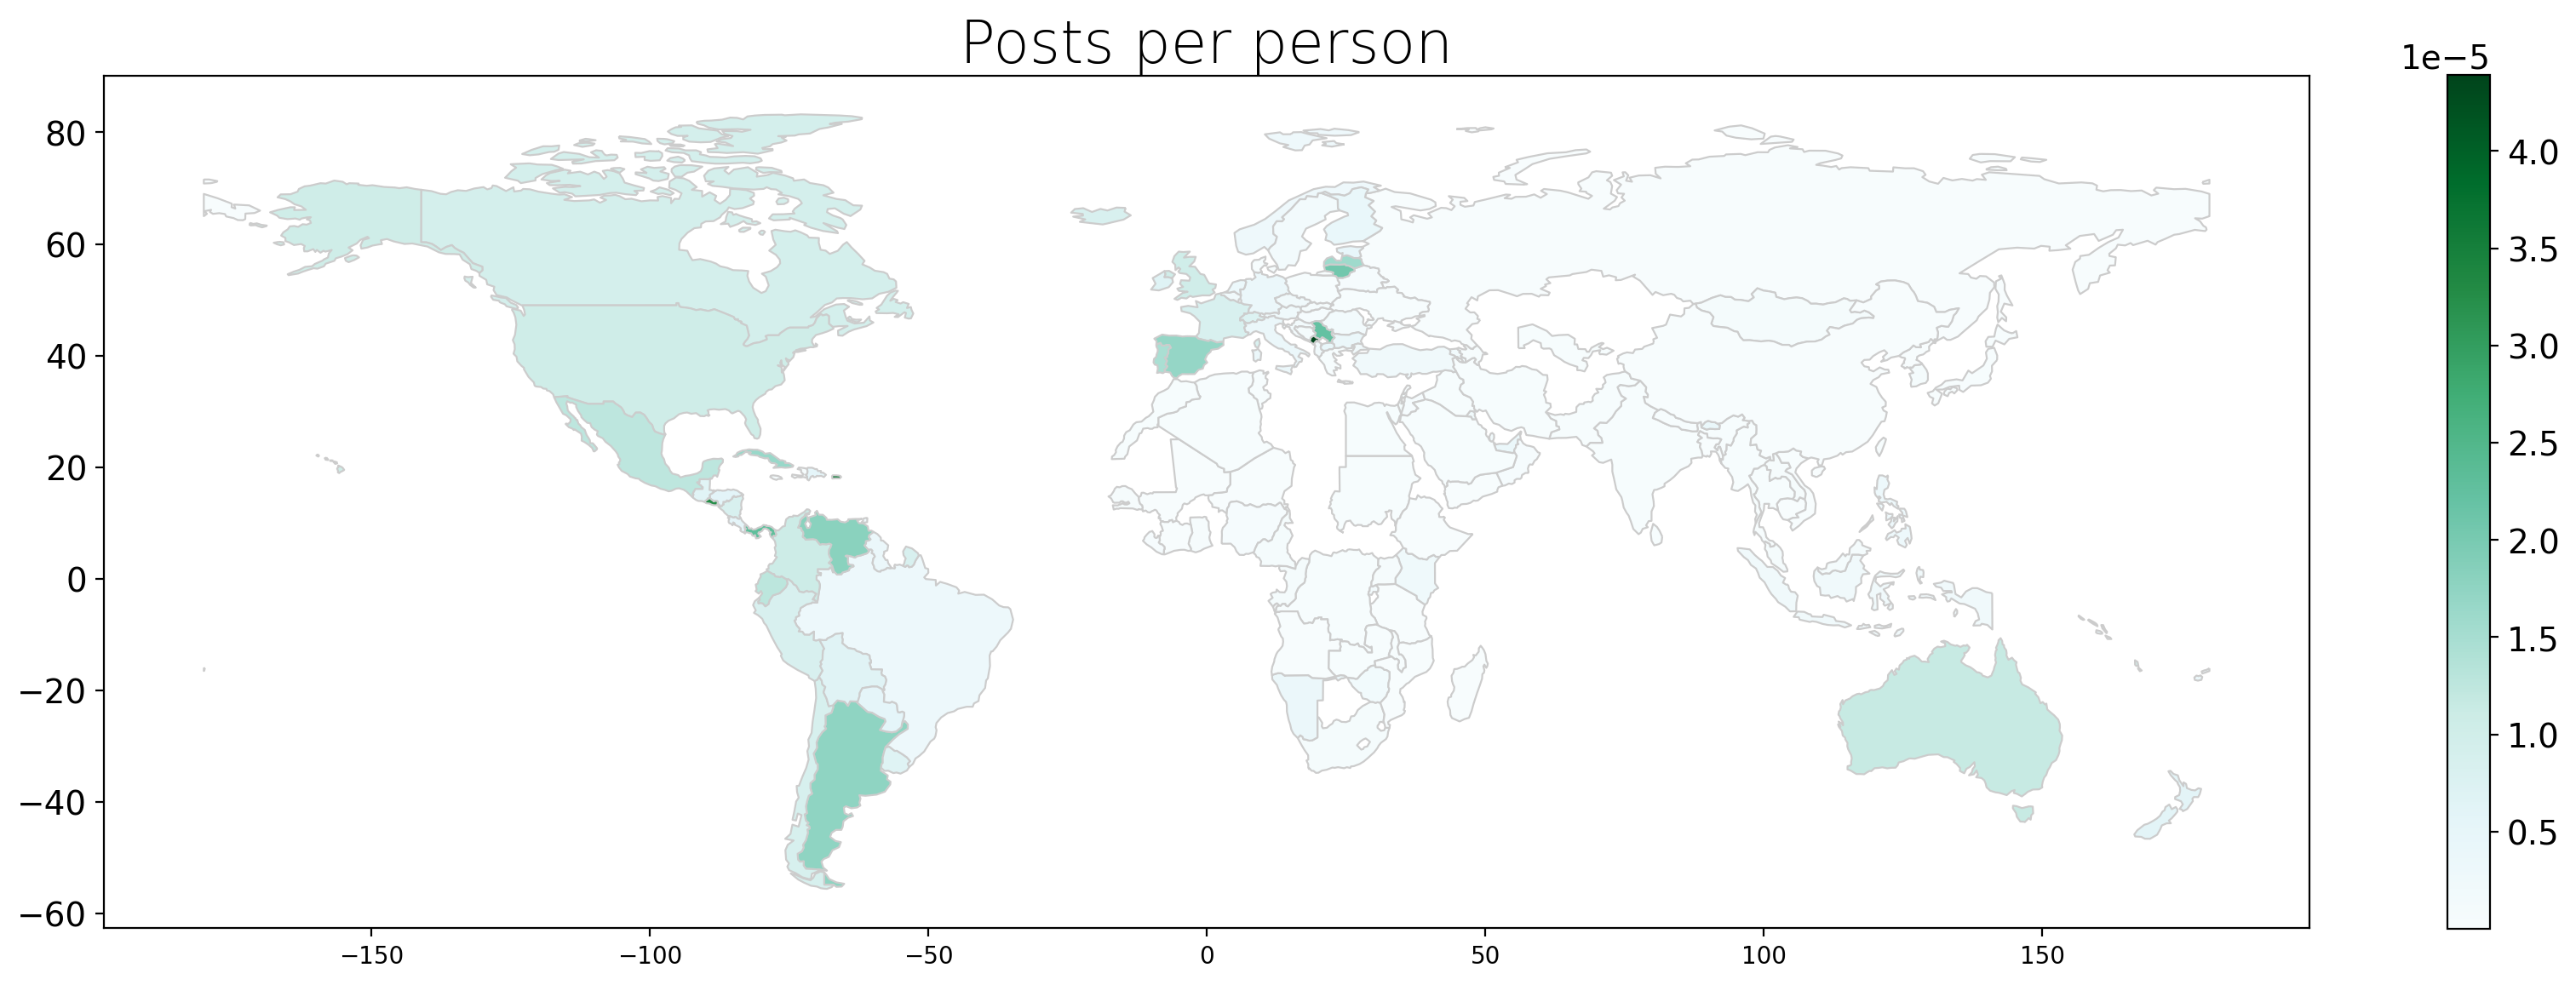

In [15]:
# set a variable that will call whatever column we want to visualise on the map
variable = "Posts_Per_Person"
# set the range for the choropleth
vmin, vmax = posts_population_ratio.Posts_Per_Person.max(), posts_population_ratio.Posts_Per_Person.min()


# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(17, 6),dpi=200)

post_per_country_map.plot(column=variable, cmap="BuGn", linewidth=0.8, ax=ax, edgecolor="0.8")

# add a title
ax.set_title("Posts per person", fontdict={"fontsize": "25", "fontweight" : "3"})

# Create colorbar as a legend
sm = plt.cm.ScalarMappable(cmap="BuGn", norm=plt.Normalize(vmin=vmin, vmax=vmax))
# empty array for the data range
sm._A = []
#add colorbar
fig.colorbar( sm,shrink=0.9)
#fig.set_facecolor("#FCF7EE")
#ax.set_facecolor("#FCF7EE")
fig.tight_layout()

#save the image
#fig.savefig("imgs/posts per person.png")

## Dependencies

In [16]:
questions_df = df[cols[4:19]]
cols_questions = cols[4:19]
questions_df =questions_df.fillna("null")
q_1_df= questions_df.groupby(by=cols_questions[0]).count().reset_index()
q_1_df = q_1_df.iloc[:,0:2]
#info_0_values = set(questions_df.iloc[:,1])
#info_0_values
q_1_df = q_1_df.rename(columns={q_1_df.columns[1]: 'count'})
q_1_df

,info_0,count
0,No,538
1,Not sure,66
2,Yes,4796
3,null,41


In [17]:
q_2_df = questions_df.groupby(by=[cols_questions[0],cols_questions[1]]).count().reset_index()
q_2_df = q_2_df.iloc[:,0:3]
q_2_df = q_2_df.rename(columns={q_2_df.columns[2]: 'count'})
q_2_df

,info_0,info_1,count
0,No,Cannot tell,10
1,No,Not answered,528
2,Not sure,Not answered,66
3,Yes,Cannot tell,492
4,Yes,No,892
5,Yes,Not answered,148
6,Yes,Yes,3264
7,null,null,41


In [18]:
q_merged_df =pd.merge(q_2_df,q_1_df, how="inner", left_on=cols_questions[0], right_on=cols_questions[0])
q_merged_df["ratio"] = q_merged_df.iloc[:,2]/q_merged_df.iloc[:,3]
cols_merged = list(q_merged_df.columns)
q_merged_df = q_merged_df[ cols_merged[0:2] +[cols_merged[4]]]
q_merged_df

,info_0,info_1,ratio
0,No,Cannot tell,0.018587
1,No,Not answered,0.981413
2,Not sure,Not answered,1.000000
3,Yes,Cannot tell,0.102585
4,Yes,No,0.185988
5,Yes,Not answered,0.030859
6,Yes,Yes,0.680567
7,null,null,1.000000


In [19]:
q_merged_df[cols_merged[1]] = cols_questions[1]+" " + q_merged_df[cols_merged[1]].astype(str)
q_merged_df
q_merged_df
vertical_stack = pd.concat([q_merged_df, q_merged_df], axis=0)


In [20]:
a = pd.DataFrame()
vertical_stack = pd.concat([a, q_merged_df], axis=0)
vertical_stack = pd.concat([vertical_stack, q_merged_df], axis=0)
vertical_stack

,info_0,info_1,ratio
0,No,info_1 Cannot tell,0.018587
1,No,info_1 Not answered,0.981413
2,Not sure,info_1 Not answered,1.000000
3,Yes,info_1 Cannot tell,0.102585
4,Yes,info_1 No,0.185988
5,Yes,info_1 Not answered,0.030859
6,Yes,info_1 Yes,0.680567
7,null,info_1 null,1.000000
0,No,info_1 Cannot tell,0.018587
1,No,info_1 Not answered,0.981413


In [21]:
questions_df = df[cols[4:19]]
cols_questions = questions_df.columns
questions_df =questions_df.fillna("null")

result = pd.DataFrame()
#for j in range(cols_questions.size):
for j in range(11):
    if(j==5 or j==6 or j==7 or j==4 or j==9 or j==10):
        continue
    q_1_df= questions_df.groupby(by=cols_questions[j]).count().reset_index()
    q_1_df = q_1_df.iloc[:,0:2]
    #for i in range(cols_questions.size):
    for i in range(11):
        if(i==5  or i==6 or i==7  or i==4 or i==9 or i==10):
            continue
        if(i==j):
            continue
        q_2_df = questions_df.groupby(by=[cols_questions[j],cols_questions[i]]).count().reset_index()
        q_2_df = q_2_df.iloc[:,0:3]
        q_merged_df =pd.merge(q_2_df,q_1_df, how="inner", left_on=cols_questions[j], right_on=cols_questions[j])
        q_merged_df["ratio"] = q_merged_df.iloc[:,2]/q_merged_df.iloc[:,3]
        cols_merged = list(q_merged_df.columns)
        q_merged_df = q_merged_df[ cols_merged[0:2] +[cols_merged[4]]]
        q_merged_df[cols_merged[1]] = cols_questions[i]+" " + q_merged_df[cols_merged[1]].astype(str)
        q_merged_df[cols_merged[0]] = cols_questions[j]+" " + q_merged_df[cols_merged[0]].astype(str)
        q_merged_df = q_merged_df.rename(columns={q_merged_df.columns[1]: 'question_2'})
        q_merged_df = q_merged_df.rename(columns={q_merged_df.columns[0]: 'question_1'})
        result = pd.concat([result, q_merged_df], axis=0)
result

,question_1,question_2,ratio
0,info_0 No,info_1 Cannot tell,0.018587
1,info_0 No,info_1 Not answered,0.981413
2,info_0 Not sure,info_1 Not answered,1.000000
3,info_0 Yes,info_1 Cannot tell,0.102585
4,info_0 Yes,info_1 No,0.185988
...,...,...,...
18,info_5 Yes,info_3 Cannot tell,0.000386
19,info_5 Yes,info_3 Not answered,0.015420
20,info_5 Yes,info_3 Some of them,0.091365
21,info_5 Yes,info_3 Yes,0.892830


In [22]:
result

,question_1,question_2,ratio
0,info_0 No,info_1 Cannot tell,0.018587
1,info_0 No,info_1 Not answered,0.981413
2,info_0 Not sure,info_1 Not answered,1.000000
3,info_0 Yes,info_1 Cannot tell,0.102585
4,info_0 Yes,info_1 No,0.185988
...,...,...,...
18,info_5 Yes,info_3 Cannot tell,0.000386
19,info_5 Yes,info_3 Not answered,0.015420
20,info_5 Yes,info_3 Some of them,0.091365
21,info_5 Yes,info_3 Yes,0.892830


In [23]:
result=result.pivot(index='question_1',columns='question_2', values=['ratio']).fillna(0)

C:\Users\livio\AppData\Local\Temp/ipykernel_5160/542681251.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(result, mask=np.zeros_like(result, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:xlabel='None-question_2', ylabel='question_1'>

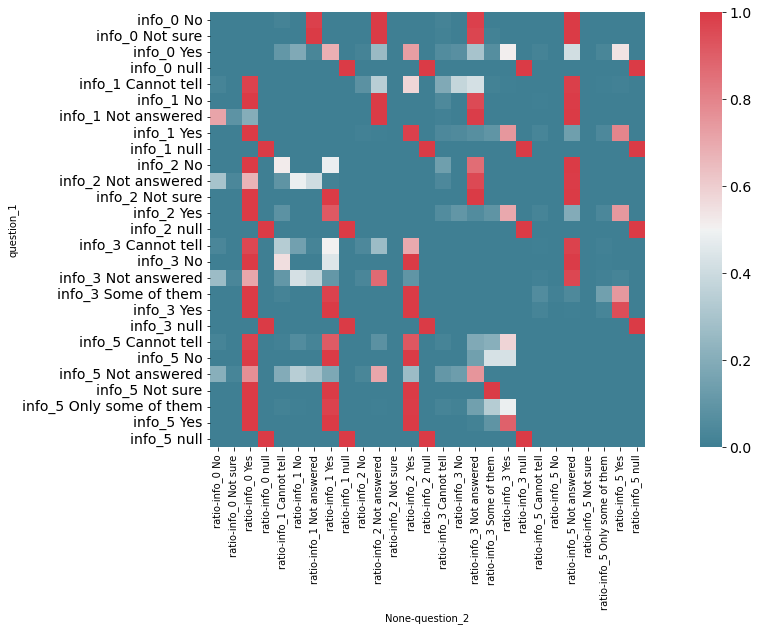

In [24]:
import seaborn as sns
import numpy as np

#print the correlation matrix
f, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(result, mask=np.zeros_like(result, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

#save image
#plt.savefig("imgs/dependency.png")

In [25]:
#set the cells with data to 1, the ones with no data to 0
ds = df_2[cols[4:19]]
invert_one_zero = {0: 1,1: 0}

ds = ds.isnull().astype(int)
ds =ds.replace(invert_one_zero)
ds

,info_0,info_1,info_2,info_3,info_4_0,info_4_1,info_4_2,info_4_3,info_5,info_6,info_7,info_8,info_9,info_10,info_11
0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1
1,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1
4,1,1,1,1,1,0,0,0,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5436,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5437,1,1,0,0,0,0,0,0,0,1,0,0,1,1,0
5438,1,1,1,1,1,0,0,0,1,1,0,0,1,1,1
5439,1,1,1,1,1,0,0,0,1,1,1,0,1,1,1


In [26]:
#compute the correlation matrix
ds.corr()

,info_0,info_1,info_2,info_3,info_4_0,info_4_1,info_4_2,info_4_3,info_5,info_6,info_7,info_8,info_9,info_10,info_11
info_0,1.000000,0.212527,0.120510,0.111849,0.105882,0.074816,0.031786,0.009656,0.090449,0.121151,0.099933,0.090250,0.098818,0.128709,0.112995
info_1,0.212527,1.000000,0.567034,0.518722,0.397887,0.312833,0.138177,0.040649,0.423495,0.544645,0.467044,0.424652,0.432247,0.553728,0.515431
info_2,0.120510,0.567034,1.000000,0.868251,0.727145,0.570708,0.252941,0.076587,0.744358,0.913865,0.803467,0.748900,0.699838,0.869593,0.854393
info_3,0.111849,0.518722,0.868251,1.000000,0.653046,0.581463,0.260635,0.082864,0.751011,0.862438,0.803158,0.710540,0.697032,0.845325,0.846399
info_4_0,0.105882,0.397887,0.727145,0.653046,1.000000,0.706603,0.300202,0.091192,0.854251,0.729352,0.682931,0.666460,0.662212,0.709678,0.703893
info_4_1,0.074816,0.312833,0.570708,0.581463,0.706603,1.000000,0.424853,0.129057,0.751250,0.564200,0.630800,0.579692,0.556212,0.540429,0.579841
info_4_2,0.031786,0.138177,0.252941,0.260635,0.300202,0.424853,1.000000,0.303769,0.336569,0.251526,0.293869,0.258518,0.246858,0.235891,0.250611
info_4_3,0.009656,0.040649,0.076587,0.082864,0.091192,0.129057,0.303769,1.000000,0.100031,0.076156,0.093231,0.083467,0.077403,0.071402,0.078508
info_5,0.090449,0.423495,0.744358,0.751011,0.854251,0.751250,0.336569,0.100031,1.000000,0.733390,0.741727,0.692302,0.660973,0.694027,0.741904
info_6,0.121151,0.544645,0.913865,0.862438,0.729352,0.564200,0.251526,0.076156,0.733390,1.000000,0.801382,0.731744,0.712491,0.906201,0.866127


C:\Users\livio\AppData\Local\Temp/ipykernel_5160/4287485795.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),


<AxesSubplot:>

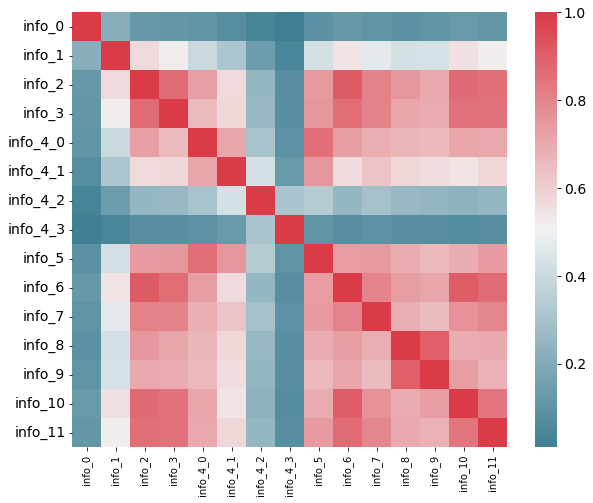

In [27]:
import seaborn as sns
import numpy as np

#print the correlation matrix
f, ax = plt.subplots(figsize=(10, 8))
corr = ds.corr(method ='pearson')
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
#save the image
#plt.savefig("imgs/correlation.png")

 ## Miscellaneous

In [28]:
#check if to each country is associated only one country code
a = df[cols[26:29]]
#a.groupby(['info_country']).info_country_code.nunique()
tab = a.groupby(['info_country_or_territory']).info_country_code.nunique().reset_index()
tab[(tab["info_country_code"] > 1)]

,info_country_or_territory,info_country_code


## Broken Links
Check if the link to the tweet is still working

Since often during the computation the program hangs, it's necessasry to restart it. In order to not restart from the beginning the progress is saved in a file *broken_links.pkl*. To start from the beginnnig it is necessary to delete the file.

In [ ]:
import requests
import time
import validators
from IPython.display import display, clear_output
import json
import pickle


links = df["info_media_url"]

try:
    with open('broken_links.pkl', "rb") as f:
        line, broken_links = pickle.load(f)
except:
    broken_links = 0
    line = 0
#in case I want to print/save the broken links    
broken_links_list = []

for link in links[line:]:
    #remove previous prints
    clear_output(wait=True)
    
    print("Reading line "+str(line + 1)+ " of "+str(length)+"\nBroken links:"+ str(broken_links))
    
    #check is the url is valid
    if not validators.url(link):
        broken_links +=1
        line+=1
        with open('broken_links.pkl', "wb") as f:
            pickle.dump([line, broken_links], f)
        continue
    
    #check if the pic is still available    
    response = requests.get(link)
    if(response.status_code > 400):
        broken_links +=1
        broken_links_list.append(link)
        
    
    line+=1

    with open('broken_links.pkl', "wb") as f:
         pickle.dump([line, broken_links], f)
    #Twitter doesn't allow more than 1 request per second
    time.sleep(1)

    
if(line == length):
    print("Broken links: "+ str(broken_links)+ " of "+str(length)+" lines")


## Pandas Profiling

In [ ]:
#import pandas_profiling
#pandas_profiling.ProfileReport(df)